<a href="https://colab.research.google.com/github/siripenp/cu-deeplearning-nvidia/blob/main/CNN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import random

from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
img_width, img_height = 224, 224
batch_size = 32
epochs = 20

#Dataset

We use dataset from [Tuberculosis Chest X-rays (Shenzhen)](https://www.kaggle.com/raddar/tuberculosis-chest-xrays-shenzhen) which contains chest x-ray images from tuberculosis patients and normal people.

In [ ]:
gdd.download_file_from_google_drive(file_id='1iWva59vbvdiWGxmcm8eX-idZNevugr-u',
                                    dest_path='./shenzhen.zip',
                                    unzip=True)

In [ ]:
metadata = pd.read_csv('/content/shenzhen_metadata.csv') # Read metadata of dataset

In [ ]:
metadata

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal
...,...,...,...,...
657,CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax
658,CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field
659,CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper at...
660,CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural th...


In [ ]:
metadata['study_id'] = '/content/images/images/' + metadata['study_id'].astype(str)

metadata['label'] = pd.Series(-1, index=metadata.index) #Add new column for number labels
metadata.loc[metadata['findings'] == 'normal','label'] = 0
metadata.loc[metadata['findings'] != 'normal','label'] = 1

In [ ]:
metadata

,study_id,sex,age,findings,label
0,/content/images/images/CHNCXR_0001_0.png,Male,45,normal,0
1,/content/images/images/CHNCXR_0002_0.png,Male,63,normal,0
2,/content/images/images/CHNCXR_0003_0.png,Female,48,normal,0
3,/content/images/images/CHNCXR_0004_0.png,Male,58,normal,0
4,/content/images/images/CHNCXR_0005_0.png,Male,28,normal,0
...,...,...,...,...,...
657,/content/images/images/CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax,1
658,/content/images/images/CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field,1
659,/content/images/images/CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper at...,1
660,/content/images/images/CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural th...,1


In [ ]:
def read_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(img_height, img_width))
    
    return image

##Data Visualization

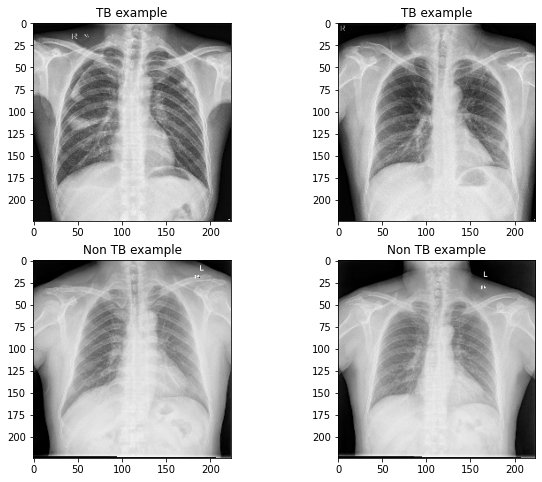

In [ ]:
f, axarr = plt.subplots(2,2,figsize=(10,8))
axarr[0,0].imshow(read_img('/content/images/images/CHNCXR_0658_1.png'))
axarr[0,0].title.set_text('TB example')
axarr[0,1].imshow(read_img('/content/images/images/CHNCXR_0659_1.png'))
axarr[0,1].title.set_text('TB example')
axarr[1,0].imshow(read_img('/content/images/images/CHNCXR_0001_0.png'))
axarr[1,0].title.set_text('Non TB example')
axarr[1,1].imshow(read_img('/content/images/images/CHNCXR_0002_0.png'))
axarr[1,1].title.set_text('Non TB example')

##Data Preprocessing

In [ ]:
X = []
y = []

for index, row in metadata.iterrows():
  X.append(read_img(row['study_id']))
  y.append(row['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

#Image Data Generator

Image data generator is used for image augmentation and loading data from directory. For more detail about image data generator, you can read at [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   horizontal_flip=True, 
                                   rotation_range=90)
valtest_datagen = ImageDataGenerator(rescale=1. / 255,featurewise_center=True,featurewise_std_normalization=True)

In [ ]:
train_datagen.fit(X_train)
valtest_datagen.fit(X_train)

In [ ]:
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size, shuffle=False)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size, shuffle=False)

#Function

In [ ]:
def plot_loss_history(hist):
  ax = plt.figure().gca()
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.ylim(0,2)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.show()
  print("Best loss at epoch: "+str(np.argmin(hist.history['val_loss'])))

In [ ]:
def plot_roc_curve(y_test,y_pred,name):

  # calculate AUROC score
  print('AUROC score: %.4f' % roc_auc_score(y_test, y_pred))

  # calculate roc curves
  model_fpr, model_tpr, _ = roc_curve(y_test, y_pred)
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--')
  plt.plot(model_fpr, model_tpr, marker='.',label=name)
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

In [ ]:
def show_prediction_result(y_test,y_pred,X_test):
  pred_dict = {1:'TB',0:'Non TB'}

  y_pred = np.round(y_pred).astype(int)

  # idx_list = [random.randint(0,len(X_test)) for i in range(4)] #random show image in test set
  idx_list = [10,20,30,40]

  f, axarr = plt.subplots(2,2,figsize=(10,8))
  axarr[0,0].imshow(X_test[idx_list[0]])
  axarr[0,0].title.set_text('Pred: '+pred_dict[y_pred.item(idx_list[0])]+', Label: '+pred_dict[y_test[idx_list[0]]])
  axarr[0,1].imshow(X_test[idx_list[1]])
  axarr[0,1].title.set_text('Pred: '+pred_dict[y_pred.item(idx_list[1])]+', Label: '+pred_dict[y_test[idx_list[1]]])
  axarr[1,0].imshow(X_test[idx_list[2]])
  axarr[1,0].title.set_text('Pred: '+pred_dict[y_pred.item(idx_list[2])]+', Label: '+pred_dict[y_test[idx_list[2]]])
  axarr[1,1].imshow(X_test[idx_list[3]])
  axarr[1,1].title.set_text('Pred: '+pred_dict[y_pred.item(idx_list[3])]+', Label: '+pred_dict[y_test[idx_list[3]]])

#Simple Convolution Neural Network

##Create model

In [ ]:
img_inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(128, 3, activation='relu')(img_inputs) # 32 is number of output filter, 3 is kernel size which has height and width equal to 3
x = layers.MaxPooling2D(pool_size=(2, 2))(x) # pooling feature from convolution layer output

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x) # flatten 2-D feature array to 1-D array
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

outputs = layers.Dense(1, activation='sigmoid')(x) # map real value into range of 0 to 1

cnn_model = keras.Model(inputs=img_inputs, outputs=outputs)

In [ ]:
cnn_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)       

In [ ]:
cnn_model.compile(
    loss=keras.losses.BinaryCrossentropy(), # Binary cross entropy is using for binary classification. If our task is multiclass classification, we will change loss to Categorical cross entropy
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

##Model Training

In [ ]:
simple_cnn_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./simple_cnn.h5',
    save_weights_only=True, 
    verbose=1,
    monitor='val_loss',
    save_best_only=True) # This callback will save model when it has a lower loss than before.


Tensorflow also provide other callbacks that are helpful when we try to adjust some parameter while training the model. You can see a list of callback at this [link](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

In [ ]:
#Try add other callback like ReduceLROnPlateau



In [ ]:
simple_cnn_history = cnn_model.fit(train_generator, 
                    validation_data=validation_generator,
                    batch_size=batch_size, 
                    callbacks=[simple_cnn_model_checkpoint_callback], # Add callback here
                    epochs=epochs,)

In [ ]:
plot_loss_history(simple_cnn_history)

##Model Evaluation

In [ ]:
cnn_model.load_weights('./simple_cnn.h5')
results = cnn_model.evaluate(test_generator)
print("test loss, test acc:", results)

In [ ]:
cnn_predictions = cnn_model.predict(test_generator)

In [ ]:
plot_roc_curve(y_test, cnn_predictions,'simple cnn')

In [ ]:
show_prediction_result(y_test, cnn_predictions, X_test)

#Dropout

##Create model

Normally, we add [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) after dense layer to reduce overfitting chance. However if model is not complex, dropout can drop the model accuracy.

In [ ]:
img_inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(128, 3, activation='relu')(img_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x) 
x = layers.Dense(128, activation='relu')(x)
#Try to add dropout

x = layers.Dense(64, activation='relu')(x)
#Try to add dropout

outputs = layers.Dense(1, activation='sigmoid')(x)

d_cnn_model = keras.Model(inputs=img_inputs, outputs=outputs)

In [ ]:
d_cnn_model.summary()

In [ ]:
d_cnn_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

###Solution

Dropout solution code

``````
img_inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(128, 3, activation='relu')(img_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x) 
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

d_cnn_model = keras.Model(inputs=img_inputs, outputs=outputs)
``````

##Model Training

In [ ]:
cnn_dropout_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./cnn+dropout.h5',
    save_weights_only=True, 
    verbose=1,
    monitor='val_loss',
    save_best_only=True)

In [ ]:
cnn_dropout_history = d_cnn_model.fit(train_generator, 
                    validation_data=validation_generator,
                    batch_size=batch_size, 
                    callbacks=[cnn_dropout_model_checkpoint_callback], 
                    epochs=epochs,)

In [ ]:
plot_loss_history(cnn_dropout_history)

##Model Evaluation

In [ ]:
cnn_model.load_weights('./cnn+dropout.h5')
results = d_cnn_model.evaluate(test_generator)
print("test loss, test acc:", results)

In [ ]:
d_cnn_predictions = d_cnn_model.predict(test_generator)

In [ ]:
plot_roc_curve(y_test, d_cnn_predictions, 'cnn+dropout')

In [ ]:
show_prediction_result(y_test, d_cnn_predictions, X_test)

# Batch Normalization

##Create model

[Batch Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layer can add between the layer and activation of that layer. We prefer to use batch normalization with dropout at dense layer but you can try to add dropout on other layer like convolutional layer or maxpooling layer.

You can split activation from layer like this

`````
x = layers.Conv2D(128, 3, activation='relu')(img_inputs)
`````

to

`````
x = layers.Conv2D(128, 3)(x)
x = layers.Activation("relu")(x)
`````

In [ ]:
#Add Batch Normalization layer into this network

img_inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(128, 3, activation='relu')(img_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x) 
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

bn_cnn_model = keras.Model(inputs=img_inputs, outputs=outputs)

In [ ]:
bn_cnn_model.summary()

In [ ]:
bn_cnn_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

###Solution

Batch Normalization solution code
`````
img_inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(128, 3)(img_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, 3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, 3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x) 
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

bn_cnn_model = keras.Model(inputs=img_inputs, outputs=outputs)
`````

##Model Training

In [ ]:
cnn_batchnorm_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./cnn+batchnorm.h5',
    save_weights_only=True, 
    verbose=1,
    monitor='val_loss',
    save_best_only=True)

In [ ]:
cnn_batchnorm_history = bn_cnn_model.fit(train_generator, 
                    validation_data=validation_generator,
                    batch_size=batch_size, 
                    callbacks=[cnn_batchnorm_model_checkpoint_callback], 
                    epochs=epochs,)

In [ ]:
plot_loss_history(cnn_batchnorm_history)

##Model Evaluation

In [ ]:
bn_cnn_model.load_weights('./cnn+batchnorm.h5')
results = bn_cnn_model.evaluate(test_generator)
print("test loss, test acc:", results)

In [ ]:
bn_cnn_predictions = bn_cnn_model.predict(test_generator)

In [ ]:
plot_roc_curve(y_test, bn_cnn_predictions, 'cnn+dropout+bn')

In [ ]:
show_prediction_result(y_test, bn_cnn_predictions, X_test)